# Optimisation of the Global Calculator via Genetic Algorithms

In [1]:
import time 
import string
import math
import random
import csv   
from functools import reduce
from openpyxl import load_workbook

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools

import selenium
from selenium import webdriver
from selenium.common.exceptions import ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
from scipy.stats import multivariate_normal

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from math import sqrt

# Set-up

In [3]:
driver = webdriver.Chrome(ChromeDriverManager().install()) # Set browser

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Driver [C:\Users\44783\.wdm\drivers\chromedriver\win32\84.0.4147.30\chromedriver.exe] found in cache


In [4]:
driver.get('http://tool.globalcalculator.org/') # Open website

In [5]:
id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
id_box.click()

In [6]:
dfs = pd.read_excel("excel_files/Output_map.xlsx") # File mapping output lever names to xpaths 
dfs_3 = pd.read_excel("excel_files/Input_map.xlsx") # File mapping input names to xpaths 
for i in range(len(dfs)): # Generate html lever addresses and put them in the dataframe
    dfs.iloc[i, 2] = '/html/body/table[1]/tbody/tr/td/table/tbody/tr[2]/td[1]/div[13]/div/table/tbody/tr[' + str(dfs.iloc[i, 1]).strip("%") + ']/td[5]/div/font' 

In [7]:
# Each letter corresponds to a lever value: a = 1.0; b = 1.1; c = 1.2; ... C = 3.9; D = 4.0
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D']
lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
output_names = list(dfs.iloc[:, 0].to_numpy()) # Create list with all output names

In [8]:
def map_to_letter(value):
    """Takes a float value in the range [1, 4.0] and returns its corresponding URL character"""
    if value != 2 and value != 3 and value != 4: # Special cases 
        if value < 4: 
            pos = int((value - 1.0)*10)
            try:
                back = letters[pos]
            except: # Oops, the value is out of bounds
                print("Not enough letters, fetching position: ", pos, " corresponding to value: ", value)
        else: # Special case: Value = 4
            back = letters[-1]
    else: 
        back = int(value)
    return back

In [9]:
def initial_chromosome():
    """Generates and return a random URL (address) and its corresponding lever values (input_levers)"""
    address = []; input_levers = []
    string = "" # URL address to be stored here
    for i in range(49): # Generate a random value for each lever, map it to a letter and save it
        rand_float = random.randint(18, 32)/10 # Define bounds for random number generator (currently set to [1.8, 3.2])
        input_levers.append(rand_float); address.append(map_to_letter(rand_float)) # Store them
    address[43:47] = [1, 1, 1, 1]  # CCS values are fixed at 1 for the moment
    input_levers[43:47] = [1, 1, 1, 1] # CCS values are fixed at 1 for the moment  
    for i in address: # Construct string containing the current lever combination
        string = string + str(i)
    address = "http://tool.globalcalculator.org/globcalc.html?levers=" + string + "2211111111/technology/en" # Construct URL address
    return address, input_levers

In [10]:
def new_URL(name, value, address = "http://tool.globalcalculator.org/globcalc.html?levers=l2wz222CBpp3pC3f2Dw3DC3plzgj1tA13pp2p223ri11111p22211111111/dashboard/en"): 
    """ 
    Generate a new URL address by changing a lever value.
        Parameters:
        - Name (string): Target lever name
        - Value (float): Target value for lever
        - Address (string): URL where lever will be changed. Set to TIAM-UCL 2DS pathway by default. 
        Returns:
        - URL (string): URL after changes. 
    """
    value = map_to_letter(value) # Map value to letter 
    index = int(find_lever_URL_position(name)) # Find URL position of given lever
    URL = address[ : 53 + index] + str(value) + address[54 + index :] # Insert given value in its corresponding URL position
    return URL 

In [11]:
def find_lever_URL_position(name): 
    """Given a lever name, return its position in the URL"""
    return str(dfs_3[dfs_3.iloc[:, 0].str.match(name)].iloc[0, 1]) # Get lever position to insert in the URL

In [12]:
def open_lever_menus():
    """Opens all the lever menus of the Global Calculator"""
    for i in range(1, 16): # Iterate through menus
        try: # Tries to open the menu
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click() # Open menu
            time.sleep(0.3) # Server can't respond quicker than this 
        except ElementClickInterceptedException: # If opening menus too fast, then slow down
            time.sleep(1)
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click()
    return

In [13]:
def new_lever_combination(threshold = False, threshold_names = [], thresholds = []):
    """Returns an array containing a random value for each lever"""
    random_lever_values = []
    if threshold == False:
        for i in range(len(lever_names)):
            random_lever_values.append(random.randint(15, 35)/10) # Generate random lever value
    else:
        for i in range(len(lever_names)):
            if lever_names[i] in threshold_names:
                lower_threshold, upper_threshold = thresholds[threshold_names.index(lever_names[i])]
                random_lever_values.append(random.randint(lower_threshold*10, upper_threshold*10)/10) # Generate random lever value
            else:
                random_lever_values.append(random.randint(15, 35)/10) # Generate random lever value
    return random_lever_values

In [14]:
def read_CO2():
    """For the current lever combination, return the CO2 level (GtCO2)"""
    userid_element = driver.find_element_by_xpath('//*[@id="container_dashboard_co2_budget"]') # Find element that contains CO2 value
    time.sleep(0.05)
    co2 = userid_element.text.splitlines()[-6] # Get CO2 value from the container
    return co2 

In [15]:
def moving_average(a, n=3) :
    """Simple moving average filter"""
    ret = np.cumsum(a, dtype=float) # Cumulative sum of input values
    ret[n:] = ret[n:] - ret[:-n] # Differences given by window length n
    return ret[n - 1:] / n # Divide by window length

In [16]:
def move_lever(lever, value, costs = False,  address = str(driver.current_url),  
               constraint = False, constraint_levers = [], constraint_values = []): 
    """
    Sets a lever to a given value. Reads corresponding temperature and, if selected, cost values. 
    Parameters:
        - lever (list of strings): Contains the names of the levers to be moved. 
        - value (list of floats): Contains the value of the levers to be moved - Automatically matched to lever names. 
        - costs (optional, boolean): Flag to decide whether to read cost values or not. 
        - address (optional, string): URL address corresponding to given lever combination. 
        - constraint (optional, boolean): Flaf to decide whether to set exact input constraints or not. 
        - constraint_levers (optional, list of strings): Contains the names of the levers to be fixed. 
        - constraint_values (optional, list of floats): Contains the values to fix the specified levers.
    Returns:
        - output (list): Contains temperature and cost values for the new lever position
    """
    # Update URL address with input lever names and values, one at a time 
    for i in range(len(lever)):
        address = new_URL(lever[i], value[i], address = address)  
    
    # Overwrite for constraint
    if constraint == True: 
        address = overwrite(constraint_levers, constraint_values, address = address)
     
    # Open website corresponding to the input values
    driver.get(address) 
    
    ########################################## IMPORTANT ####################################################
    # All of the lines below are in charge of webscraping the temperature and, if selected, the cost values. 
    # The Global Calculator is a hard to webscrape website (sometimes, it results in bugs or uncoherent
    # temperature and cost values). The code below ensures that, no matter what, the values will be read. 
    # To do so it performs different actions based on the current state of the website and the output values. 
    #########################################################################################################
    
    time.sleep(0.2)
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
    id_box.click()
    time.sleep(1)
    
    # Read temperature values
    try:
        time.sleep(0.1)
        output = int(read_CO2()[:4]) # Read output CO2
    except: # Problem reading output CO2? The code below sorts it
        time.sleep(1)
        open_lever_menus() # Open lever menus
        move_lever([lever[0]],[1.3], costs = False) # Move lever to an arbitrary value
        driver.get(address) # Open website back 
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        time.sleep(0.1)
        output = int(read_CO2()[:4]) # Read output CO2
        
    # Read cost values   
    if costs == True:   
        driver.find_element_by_xpath('//*[@id="mn-6"]').click() # Move to compare tab 
        time.sleep(0.2)
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[11]') # Read GDP
        cost_output = userid_element.text
        try:
            cost_output = float(cost_output[:4].rstrip("%")) # Convert GDP from string to float
        except: # Problem converting GDP? The code below sorts it
            cost_output = float(cost_output[:3].rstrip("%"))
        
        # Reload the page and bypass start
        driver.refresh() # Refresh
        time.sleep(1)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[12]') # Read text below GDP value
        cost_flag = userid_element.text   
        
        # Find sign of GDP (less expensive => increase; more expensive => decrease)
        if cost_flag == 'less expensive': 
            cost_output = -cost_output # Reverse sign
            
        # Go back to the overview section
        try:
            driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
        except: # Problem going back to the overview section? The code below sorts it
            time.sleep(0.2)
            id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
            id_box.click()
        output = [output, cost_output] # Output temperature and cost values
    return  output

In [17]:
def iterate(iterations = 5, population_size = 30, 
            constraint = False, constraint_levers = [], constraint_values = [], 
            output_constraint = False, output_constraint_names = [], output_constraints = [],
            threshold = False,  threshold_names  = [], thresholds = [],   
            std_devs = [] ):
    """
    Given a set of constraints performs GA iteration(s) on the Global Calculator.
    Parameters:
        - iterations (int): Number of GA iterations. 
        - population_size (int): Number of chromosomes per iteration. 
        - constraint (boolean): Flag to decide whether to fix input levers or not. 
        - constraint_levers (list of strings): Contains the names of the levers to be fixed. 
        - constraint_Values (list of floats): Contains the values of the levers to be fixed. 
        - output_constraint (boolean): Flag to decide whether to fix outputs or not. 
        - output_constraint_names (list of strings): Contains the names of the output to be fixed. 
        - output_constraints (list of floats): Contains the values of the output to be fixed. 
        - threshold (boolean): Flag to decide whether to bound levers within a range or not. 
        - threshold_names (list of strings): Contains the names of the levers to be bounded within a range. 
        - thresholds (list of list of floats): Contains the upper and lower threshold to bound the specified levers. 
    Returns:
        - all_fitness (list of floats): Contains the total fitness value of each generation.
        - lever_values (list of lists of floats): Contains the lever values of all the chromosomes from the last generation.
    """
    legends = []
    all_fitness = []; lever_values = []; results = []; output_values = []
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    
    # Initialise population randomly
    for i in range(population_size): # Population size
        
        # Generate chromosome and read associated temperature, cost and other output values
        lever_values_temp, temperature_cost_temp = generate_chromosome(constraint = constraint, constraint_levers = constraint_levers, constraint_values = constraint_values, threshold = threshold, threshold_names  = threshold_names, thresholds = thresholds)  # Generate chromosome
        lever_values.append(lever_values_temp)
        results.append(temperature_cost_temp) # Calculate temperature and cost values associated to chromosome
        if output_constraint == True: # If output constraint set, read output
            output_values.append(read_outputs())      
        
    # Perform iterations of GA
    for j in range(iterations): # Fixed number of iterations (replace by tolerance later on)
        plt.figure(figsize = (16, 9))
        if plot == True:
            c = next(palette)
            # Plotting routine
            for pair in results:
                plt.plot(pair[0], pair[1], '.',  color=c) # color='darkorange'
            plt.xlim(0, 6000)
            plt.ylim(-12, 2)
            plt.xlabel("Temperature values", fontsize = 15)
            plt.ylabel("Cost values", fontsize = 15)
            plt.title("Population evolution", fontsize = 20)
            legends.append("Generation " + str(j))
            #plt.show()
        
        # Evaluate fitness
        fitness_values = []
        for i in range(len(results)):
            fitness_values.append(fitness(results[i], output_constraint = output_constraint, current_output_values = output_values[i], output_constraint_names =  output_constraint_names, output_constraints = output_constraints, std_devs = std_devs)) 
        all_fitness.append(sum(fitness_values)) # Find sum of fitness
        
        # Find fittest candidates <=> Parents  
        fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:2] # Find the fittest 2
        parent_1 = lever_values[fittest_index [0]] # Find lever combination of parent 1
        parent_2 = lever_values[fittest_index [1]] # Lever combination of aprent 2
        
        # Printing routine
        print("Generation: ", j+1, "; Fitness is: ", sum(fitness_values))
        print("Temperature and cost values: ", results[fittest_index[0]], "; ", results[fittest_index[1]])
        print("Parents:")
        print(parent_1)
        print(parent_2, "\n")
        
        # Crossover and mutation
        for i in range(len(lever_values)): # Perform crossover by mating parents using uniform crossover (high mutation prob)
            
            # If some inputs are bounded within thresholds, take into account when mating
            if lever_names[i] in threshold_names:
                th = thresholds[threshold_names.index(lever_names[i])] # Temporary variable containing current threshold
                lever_values[i] = mate(parent_1, parent_2, threshold = True, threshold_value = th) # Generates full new set of lever combination
            
            # Otherwise mate right away
            else:
                lever_values[i] = mate(parent_1, parent_2) # Generates full new set of lever combinations
        
        results = []; output_values = []
        
        # Calculate temperature and cost of each lever combination and overwrite lever values according to constraints
        for lever_combination in lever_values: # For each chromosome
            lever_combination_temp = lever_combination # Store it in a temp variable
            # Overwrite lever values with constraints. If current lever is not constrained, it does nothing 
            lever_names, lever_combination = overwrite_lever_values(lever_names, lever_combination, constraint_levers, constraint_values)
            lever_values[lever_values.index(lever_combination_temp)] = lever_combination # Set current lever values after constraint
            # Read temperature and cost values for given lever combination (w or w/o constraint)
            results.append(move_lever(lever_names, lever_combination, costs = True, constraint = constraint,  constraint_levers = constraint_levers, constraint_values = constraint_values))
            # Read outher output values for current lever combination
            if output_constraint == True:
                output_values.append(read_outputs())
    plt.legend(legends)
    plt.show()
    return all_fitness, lever_values

## Creating a new generation

In [18]:
def generate_chromosome(constraint = False, constraint_levers = [], constraint_values = [], 
                        threshold = False, threshold_names = [], thresholds = []):
    """
    Initialises a chromosome and returns its corresponding lever values, and temperature and cost. 
    Parameters:
        - constraint (boolean): Flag to select whether any inputs have been fixed. 
        - constraint_levers (list of strings): Contains the name of levers to be fixed.  
        - constraint_values (list of floats): Contains the values to fix the selected levers to. 
        - threshold (boolean): Flag to select whether any inputs have to be bounded within a range. 
        - threshold_names (list of strings): Contains the name of the levers to be bounded within a range. 
        - thresholds (list of lists of floats): Contains the upper and lower bound for each specified lever. 
    Returns:
        - random_lever_values (list of floats): Contains lever values corresponding to generated chromosome. 
        - result (list): Contains temperature and cost values corresponding to the current chromosome. 
    """
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    # Generate random lever combination
    random_lever_values = new_lever_combination(threshold = threshold, threshold_names = threshold_names, thresholds = thresholds) 
    # Fix specified input levers
    if constraint == True:
        lever_names, random_lever_values = overwrite_lever_values(lever_names, random_lever_values, constraint_levers,  constraint_values)
    result = move_lever(lever_names, random_lever_values, costs = True, constraint = constraint, constraint_levers = constraint_levers, constraint_values = constraint_values) # Move lever accordingly and read temperature and cost valuesw
    return random_lever_values, result

## Fitness function

In [19]:
def fitness(chromosome, target_temperature = 3000, target_cost = 0, output_constraint = False, current_output_values = [], output_constraint_names = [], output_constraints = [], std_devs = []):
    """Need to apply some sort of normalisation. Divide by standard deviation"""
    total_cost = 0 # Initialise fitness
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    output_names = list(dfs.iloc[:, 0].to_numpy()) # Create list with all output names
    if output_constraint == True: # If output constraints have been set, take into account in fitness function
        for i in range(len(output_constraint_names)): # Iterate through output constraints
            if output_constraint_names[i] in  output_names: # Ensure name is correct, otherwise ignore constraint
                # Equality constraint of specified output value. Normalised by diving it by an estimate of its standard deviation. 
                total_cost += (abs(current_output_values[output_names.index(output_constraint_names[i])] - output_constraints[i]))/std_devs[output_names.index(output_constraint_names[i])]
    # Equality constraint for temperature value and inequality constraint for cost value (normalised with their approxiamte std dev)
    total_cost += (abs(chromosome[0] - target_temperature)/18204.97) + ((chromosome[1] - target_cost)/34.59)
    return  total_cost

## Selection

In [20]:
def selection(fitness_values):
    """Given an array of fitness values, find the indeces and the values of the 2 fittest candidates -> Parents"""
    fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:2] # Find 2 fittest candidates
    parent_1, parent_2 = lever_values[fittest_index [0]], lever_values[fittest_index [1]] # Find values of parents
    return parent_1, parent_2, fittest_index

## Mutation 

In [21]:
def mutated_genes(lever_value, thresholds = [1, 3.9], threshold = False, threshold_name = "", threshold_value = ""):
    """Mutate gene by randomly moving a lever up or down by 0.1. Returns the mutated gene (the new lever value)"""
    move = -0.
    prob = random.randint(0, 100)/100 # Generate random gene
    if prob < 0.5: move = -0.1 # Move lever down
    else: move = 0.1 # Move lever up
    # If the lever value is out of bounds, reverse direction of step (taking specified threshold into account)
    if threshold == True:
        if (lever_value + move < threshold_value[0]) or (lever_value + move > threshold_value[1]):
            move = -move
    else:
        if (lever_value + move < thresholds[0]) or (lever_value + move > thresholds[1]):
            move = -move
    return round(lever_value + move, 3)

## Crossover 

In [22]:
def mate(parent_1, parent_2, threshold = False, threshold_name = "", threshold_value = ""): 
        ''' Takes a couple of parents, performs crossover, and returns resulting child. '''
        child_chromosome = [] 
        for p1, p2 in zip(parent_1, parent_2):     
            prob = random.random()  # Generate random value
            if prob < 0.4: # Select gene from 1st parent
                child_chromosome.append(p1) 
            elif prob < 0.8: # Select gene from 2nd parent
                child_chromosome.append(p2) 
            elif prob < 0.9: 
                child_chromosome.append(mutated_genes(p1, threshold = threshold, threshold_name = threshold_name, threshold_value = threshold_value))  # Mutate gene from 1st parent
            else:
                child_chromosome.append(mutated_genes(p2, threshold = threshold, threshold_name = threshold_name, threshold_value = threshold_value)) # Mutate gene from 2nd parent
        return child_chromosome

## Setting multiple constraints

### Setting input constraints

In [23]:
def overwrite(levers, values, address = str(driver.current_url)):
    """Given a set of lever names and corresponding values, overwrite specified lever combination"""
    for i in range(len(levers)): # Overwrite 1 value at a time
        address = new_URL(levers[i], values[i], address = address)  
    return address

def overwrite_lever_values(levers, values, constraint_levers, constraint_values):
    """
    Given a set of lever names and corresponding values, and a set of 
    constrained lever names and their values, return the corresponding lever combination and its values. 
    """
    for i in range(len(levers)): # Iterate through all levers
        if levers[i] in constraint_levers: # If current lever is constrained
            values[i] = constraint_values[constraint_levers.index(levers[i])] # Update
    return levers, values

### Setting output constraints

In [24]:
def read_outputs():
    """Reads all outputs and returns them as a list (empirical scraping)"""
    time.sleep(0.2) 
    compare_box = driver.find_element_by_xpath('//*[@id="mp-nav-compare"]') # Move to the "Compare" section
    time.sleep(0.1)
    try: 
        compare_box.click()
    except:
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        time.sleep(0.1)
        compare_box.click()
    out_vals = []
    for i in range(len(dfs)): 
        userid_element = driver.find_element_by_xpath(dfs.iloc[i, 2])
        out_vals.append(float(userid_element.text.rstrip("%")))
    time.sleep(0.1)   
    try:
        driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
    except: # Problem going back to the overview section? The code below sorts it
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
    return out_vals

# Mapping covariance matrix to custom lever jump

In [25]:
def move_levers_randomly(vals, p_1, p_2, p_3):
    for i in range(len(vals)):
        vals[i] = lever_step(vals[i], p = [p_1/2, p_1/2, p_2/2, p_2/2,  p_3/2,  p_3/2])
    return vals.copy()

In [26]:
def combination(seed_lever_values, probs, samples = 10):
    mus = []; sigmas = []
    for prob in probs:
        #print(prob)
        p_1, p_2, p_3 = prob[0], prob[1], prob[2]
        lever_values = []; output_values = []
        initial_lever_values = seed_lever_values.copy()
        #print(initial_lever_values)
        for i in range(samples): # Generate 20 random lever combinations
            random_lever_values = move_levers_randomly(initial_lever_values.copy(), p_1, p_2, p_3) # Move levers randomly according to a certain probability
            #print(random_lever_values)
            temp = move_lever(lever_names, random_lever_values, costs = True) # Move lever accordingly
            if (temp[0] > 1000) and (temp[1]>-14): # Check for spurious values
                lever_values.append(temp)
        sample_frame = pd.DataFrame(lever_values)
        mus.append([sample_frame.iloc[:, 0].mean(), sample_frame.iloc[:, 1].mean()])
        sigmas.append([sample_frame.iloc[:, 0].std(), sample_frame.iloc[:, 1].std()])
    for pair in sigmas:
        plt.plot(pair[0], pair[1], 'o')
        plt.xlabel("$\sigma_{GHG}$ ")
        plt.ylabel("$\sigma_{GDP}$ ")
    return mus, sigmas

In [27]:
def lever_step(lever_value, thresholds = [1, 3.9], threshold = False, threshold_name = "", threshold_value = "", p = [0.5, 0.5, 0, 0, 0, 0]):
    """Mutate gene by randomly moving a lever up or down by 0.1. Returns the mutated gene (the new lever value)"""
    move = -0.
    prob = random.randint(0, 100)/100 # Generate random gene
    if prob < p[0]: 
        #print("Lever down 1")
        move = -0.1 # Move lever down
    elif prob < p[0] + p[1]: 
        #print("Lever up 1")
        move = 0.1 # Move lever up
    elif prob < p[0] + p[1] + p[2]: 
        #print("Lever down 2")
        move = -0.2 # Move lever down
    elif prob < p[0] + p[1] + p[2] + p[3]: 
        #print("Lever up 2")
        move = 0.2 # Move lever up
    elif prob < p[0] + p[1] + p[2] + p[3] + p[4]: 
        #print("Lever down 3")
        move = -0.3 # Move lever down
    elif prob < p[0] + p[1] + p[2] + p[3] + p[4] + p[5]: 
        move = 0.3 # Move lever up
        #print("Lever up 3")
    # If the lever value is out of bounds, reverse direction of step (taking specified threshold into account)
    if threshold == True:
        if (lever_value + move < threshold_value[0]) or (lever_value + move > threshold_value[1]):
            move = -move
    else:
        if (lever_value + move < thresholds[0]) or (lever_value + move > thresholds[1]):
            move = -move
    return round(lever_value + move, 3)

In [28]:
def generate_probs():
    p1 = random.randint(0, 66)/100
    p2 = random.randint(0, 100)/100
    p2 = (1 - p1)*p2
    p3 = 1 - (p2 + p1)
    return [p1, p2, p3]

generate_probs()

[0.64, 0.1188, 0.24119999999999997]

In [29]:
lattice = [[0, 0, 1], 
          [0, 1, 0], 
          [1, 0, 0],
          [0, 0.33, 0.66], 
          [0, 0.5, 0.5],
          [0, 0.66, 0.33],
          [0.33, 0.66, 0],
          [0.5, 0.5, 0], 
          [0.66, 0.33, 0],
          [0.66, 0, 0.33],
          [0.5, 0, 0.5],
          [0.33, 0, 0.66], 
          [0.33, 0.33, 0.33]]
probs = lattice.copy()

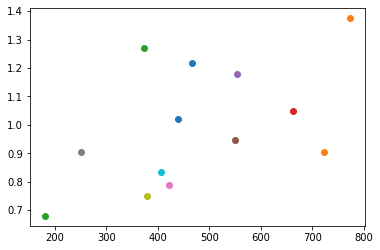

In [156]:
#probs = [[1, 0, 0],
#        [0.5, 0.5, 0], 
#        [0.33, 0.33, 0.33]]
#probs = []
#for i in range(15):
#    probs.append(generate_probs())

seed_lever_values = [2.1, 2.0, 3.2, 3.5, 2.0, 2.0, 2.0, 3.8, 3.7, 2.5, 2.5, 3.0, 2.5, 3.8, 3.0, 1.5, 2.0, 3.9, 3.2, 3.0, 3.9, 3.8, 2.1, 3.0, 2.5, 3.5, 1.6, 1.9, 1.0, 2.9, 3.6, 1.0, 3.0, 2.5, 2.5, 2.0, 2.0, 2.0, 2.5, 3.0, 2.7, 1.8, 2.5, 1.0, 1.0, 1.0, 1.0, 2.0]
mus, sigmas = combination(seed_lever_values, probs, samples = 30)

In [160]:
sigmas_map = sigmas.copy()
sigmas_map

[[465.84084031538833, 1.2165024767184278],
 [721.965504477307, 0.9058035107019623],
 [182.12953581473806, 0.680418735171522],
 [663.6170790344435, 1.047662367741444],
 [553.6446638351204, 1.1778616900636256],
 [551.0077538724715, 0.9480603914029562],
 [422.23206017979993, 0.7875231067582468],
 [251.2652785998994, 0.9038526097931482],
 [379.2344814939999, 0.75139632470595],
 [405.79866617728595, 0.8347978625178479],
 [439.5726712766995, 1.0208865315718627],
 [772.9367054130064, 1.3747262632431863],
 [374.33272981511715, 1.2688990029954927]]

In [122]:
test_sigma = [500, 0.75]
distance = []
for i in range(len(sigmas_map)):
    distance.append(sqrt(abs(test_sigma[0] - sigmas_map[i][0])**2 + abs(test_sigma[1] - sigmas_map[i][1])**2))
closest_index = sorted(range(len(distance)), key = lambda sub: distance[sub])[:1][0] # Find the closest 

In [123]:
closest_index 

1

# What happens if we move levers randomly by 0.1, 0.2 or 0.3? Visualise std. dev. 

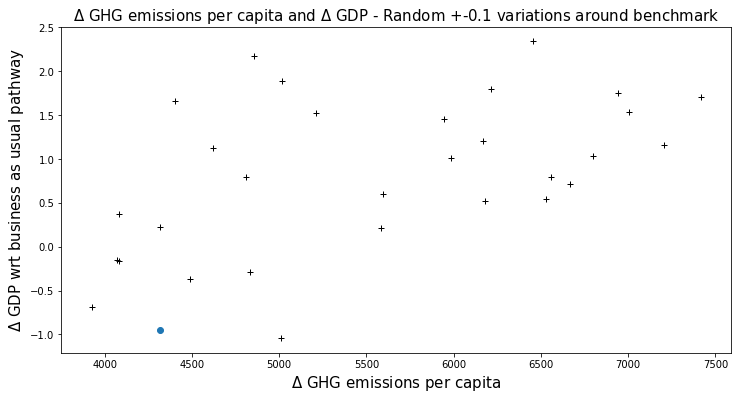

In [45]:
# Initialise population randomly
lever_values_temp, temperature_cost_temp = generate_chromosome() 
address = str(driver.current_url)
plt.figure(figsize = (12, 6))
plt.plot(temperature_cost_temp[0], temperature_cost_temp[1], 'o' )
for i in range(30): # Population size

    # Generate chromosome and read associated temperature, cost and other output values
     # Generate chromosome
    #print(lever_values_temp)
    new_lever_values = move_levers_randomly(lever_values_temp, 1, 0, 0)
    temperature_cost_temp = move_lever(lever_names, new_lever_values, costs = True, address = address)
    plt.plot(temperature_cost_temp[0], temperature_cost_temp[1], '+', color = 'black' )
    if(temperature_cost_temp[1] > -15):
        plt.xlabel("$\Delta$ GHG emissions per capita", fontsize = 15)
        plt.ylabel("$\Delta$ GDP wrt business as usual pathway", fontsize = 15)
        plt.title("$\Delta$ GHG emissions per capita and $\Delta$ GDP - Random +-0.1 variations around benchmark", fontsize = 15)

    #results.append(temperature_cost_temp) # Calculate temperature and cost values associated to chromosome
    #if output_constraint == True: # If output constraint set, read output
    #    output_values.append(read_outputs())      

# Perform a single iteration

In [196]:
def iterate(iterations = 5, population_size = 30, 
            constraint = False, constraint_levers = [], constraint_values = [], 
            output_constraint = False, output_constraint_names = [], output_constraints = [],
            threshold = False,  threshold_names  = [], thresholds = [], 
            plot = False,
            std_devs = [] ):
    
    legends = []
    all_fitness = []; lever_values = []; results = []; output_values = []
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    plt.figure(figsize = (16, 9))
    # Initialise population randomly
    for i in range(population_size): # Population size
        
        # Generate chromosome and read associated temperature, cost and other output values
        lever_values_temp, temperature_cost_temp = generate_chromosome(constraint = constraint, constraint_levers = constraint_levers, constraint_values = constraint_values, threshold = threshold, threshold_names  = threshold_names, thresholds = thresholds)  # Generate chromosome
        lever_values.append(lever_values_temp)
        results.append(temperature_cost_temp) # Calculate temperature and cost values associated to chromosome
        if output_constraint == True: # If output constraint set, read output
            output_values.append(read_outputs())      
        
    # Perform iterations of GA
    for j in range(iterations): # Fixed number of iterations (replace by tolerance later on)   
        # Plotting routine
        if plot == True:
            c = next(palette)
            for pair in results:
                plt.plot(pair[0], pair[1], '.',  color=c) #'darkorange' 
            plt.xlim(0, 6000)
            plt.ylim(-12, 2)
            plt.xlabel("Temperature values")
            plt.ylabel("Cost values")
            plt.title("Population evolution")
            legends.append("Generation " + str(j))
            #plt.show()
            
        
        ## Evaluate fitness
        fitness_values = []
        for i in range(len(results)):
            fitness_values.append(fitness(results[i])) 
        all_fitness.append(sum(fitness_values)) # Find sum of fitness
        
        ## Find index of 5 fittest values (25%)
        fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:6] # Find the fittest 2
        
        # Calculate sigma of fittest values 
        sigmas = []
        for i in fittest_index:
            sigmas.append(results[i])
        sample_frame = pd.DataFrame(sigmas)
        sigmas = []
        sigmas.append([sample_frame.iloc[:, 0].std(), sample_frame.iloc[:, 1].std()])

        
        # Calculate distance from sigmas map
        distance = []
        for i in range(len(sigmas_map)):
            distance.append(sqrt(abs(sigmas[0][0] - sigmas_map[i][0])**2 + abs(sigmas[0][1] - sigmas_map[i][1])**2))
        closest_index = sorted(range(len(distance)), key = lambda sub: distance[sub])[:1][0] # Find the closest
        plt.figure(figsize = (10, 6))
        for pair in sigmas_map:
            plt.plot(pair[0], pair[1], 'o')
            plt.xlabel("$\sigma_{GHG}$ ")
            plt.ylabel("$\sigma_{GDP}$ ")
            plt.xlim(0, 800)
            plt.ylim(0, 2)
        plt.plot(sigmas[0][0], sigmas[0][1], 'x')
        plt.show()
        
        
        
        # Find new lever values according to sigmas map
        results = []
        probabilities = probs[closest_index]
        print("Sigmas are: ", sigmas, "Picking probability level: ", closest_index)
        for i in range(len(lever_values)):
            lever_values[i] = move_levers_randomly(lever_values[i], probabilities[0], probabilities[1], probabilities[2])
            results.append(move_lever(lever_names, lever_values[i], costs = True)) # Move lever accordingly and read temperature and cost valuesw        
        
        
        
        ## Find fittest candidates <=> Parents  
        #fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:2] # Find the fittest 2
        #parent_1 = lever_values[fittest_index [0]] # Find lever combination of parent 1
        #parent_2 = lever_values[fittest_index [1]] # Lever combination of aprent 2
        
        ## Printing routine
        print("Generation: ", j+1, "; Fitness is: ", sum(fitness_values))
        print("Temperature and cost values: ", results[fittest_index[0]], "; ", results[fittest_index[1]])
        print("Fittest candidate has fitness of: ", min(fitness_values))
        #print("Parents:")
        #print(parent_1)
        #print(parent_2, "\n")
        
        # Crossover and mutation
        #for i in range(len(lever_values)): # Perform crossover by mating parents using uniform crossover (high mutation prob)
        #    
        #    # If some inputs are bounded within thresholds, take into account when mating
        #    if lever_names[i] in threshold_names:
        #        th = thresholds[threshold_names.index(lever_names[i])] # Temporary variable containing current threshold
        #        lever_values[i] = mate(parent_1, parent_2, threshold = True, threshold_value = th) # Generates full new set of lever combination
        #    
        #    # Otherwise mate right away
        #    else:
        #        lever_values[i] = mate(parent_1, parent_2) # Generates full new set of lever combinations
        
        #results = []; output_values = []
        
        ## Calculate temperature and cost of each lever combination and overwrite lever values according to constraints
        #for lever_combination in lever_values: # For each chromosome
        #    lever_combination_temp = lever_combination # Store it in a temp variable
        #    # Overwrite lever values with constraints. If current lever is not constrained, it does nothing 
        #    lever_names, lever_combination = overwrite_lever_values(lever_names, lever_combination, constraint_levers, constraint_values)
        #    lever_values[lever_values.index(lever_combination_temp)] = lever_combination # Set current lever values after constraint
        #    # Read temperature and cost values for given lever combination (w or w/o constraint)
        #    results.append(move_lever(lever_names, lever_combination, costs = True, constraint = constraint,  constraint_levers = constraint_levers, constraint_values = constraint_values))
        #     # Read outher output values for current lever combination
        #    if output_constraint == True:
        #        output_values.append(read_outputs())
    plt.legend(legends)
    plt.show()
    return all_fitness, lever_values

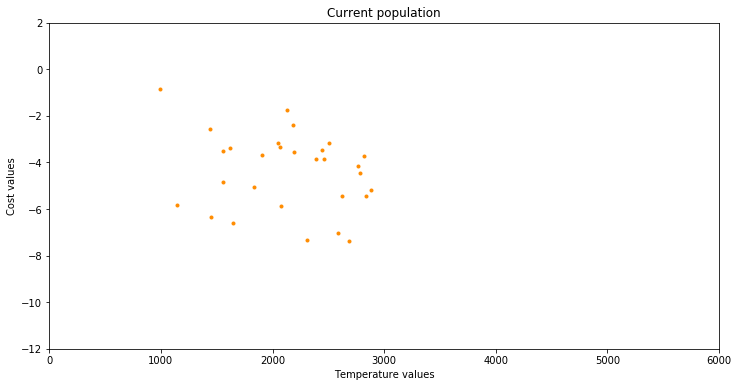

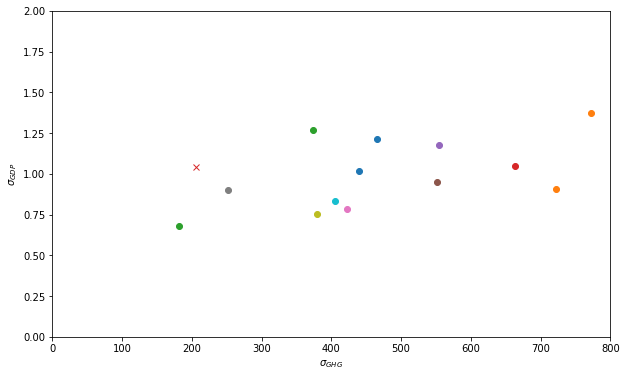

Sigmas are:  [[205.24327029162248, 1.04091145957121]] Picking probability level:  2
Generation:  1 ; Fitness is:  -2.0847823308116595
Temperature and cost values:  [2841, -7.03] ;  [2618, -6.87]
Fittest candidate has fitness of:  -0.19581932329700122


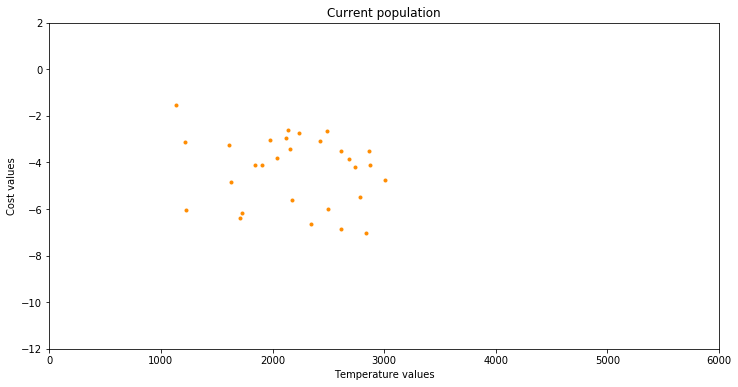

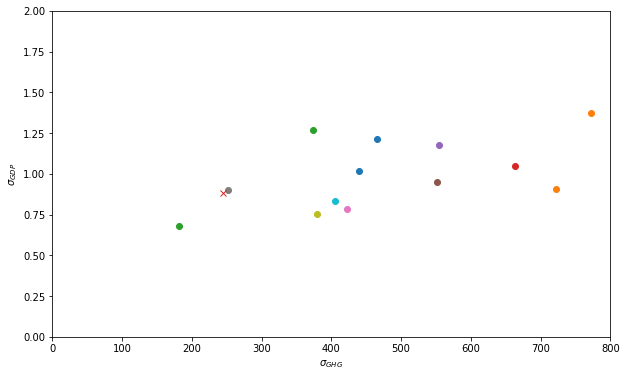

Sigmas are:  [[243.9536158097819, 0.8832893070789436]] Picking probability level:  7
Generation:  2 ; Fitness is:  -2.060212334694735
Temperature and cost values:  [2985, -6.99] ;  [2858, -6.86]
Fittest candidate has fitness of:  -0.19450405132204554


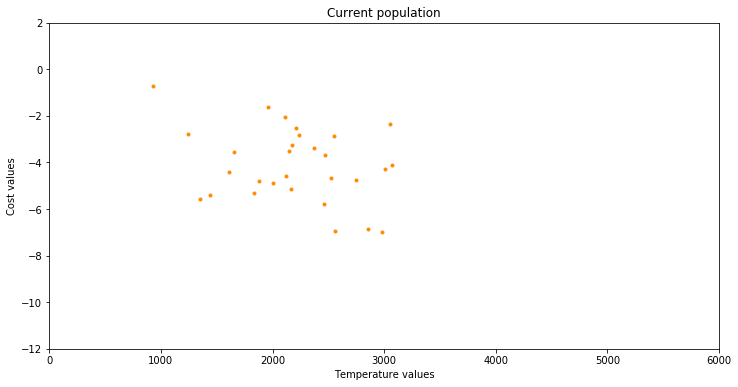

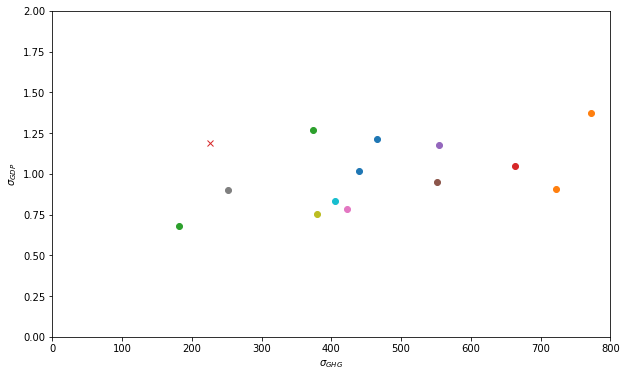

Sigmas are:  [[225.57038812751998, 1.1902394717030689]] Picking probability level:  7
Generation:  3 ; Fitness is:  -1.9363328218011282
Temperature and cost values:  [4093, -6.85] ;  [2734, -7.51]
Fittest candidate has fitness of:  -0.20125757563051147


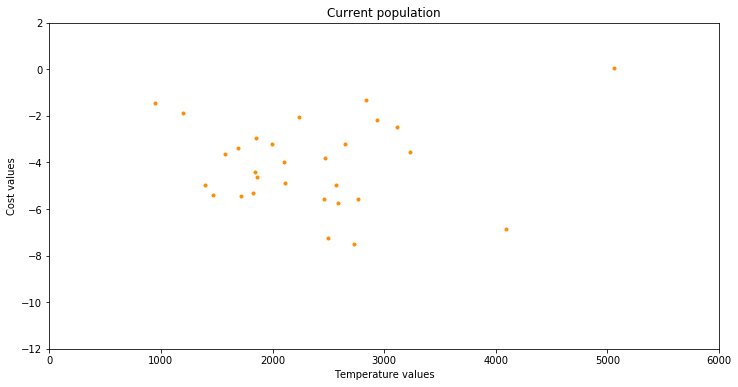

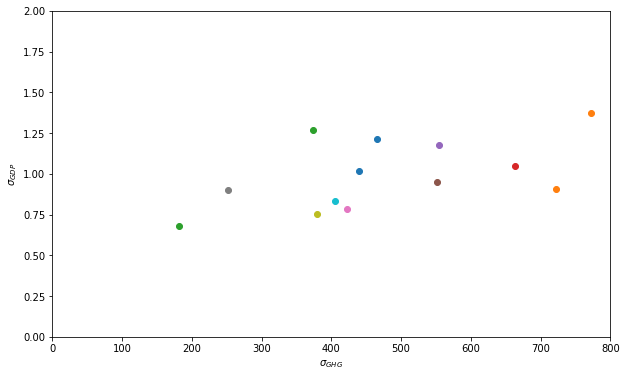

Sigmas are:  [[595.8660084280693, 9.186606373774087]] Picking probability level:  4
Generation:  4 ; Fitness is:  -2.789132518789477
Temperature and cost values:  [3375, -3.66] ;  [2959, -5.59]
Fittest candidate has fitness of:  -0.8283403989859665


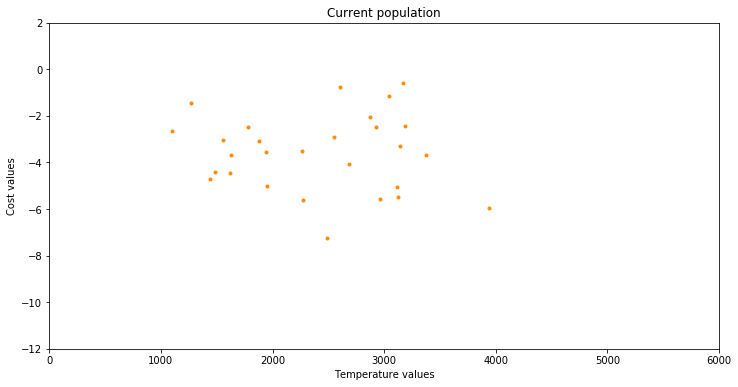

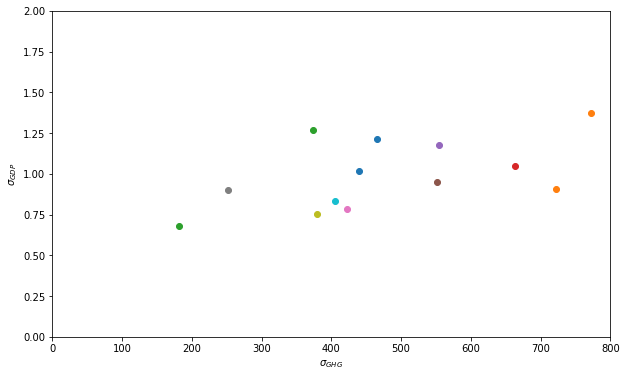

Sigmas are:  [[548.6876767949747, 9.745864080042708]] Picking probability level:  5
Generation:  5 ; Fitness is:  -2.425244951158441
Temperature and cost values:  [2150, -1.9] ;  [2738, -6.59]
Fittest candidate has fitness of:  -0.7870211542166319


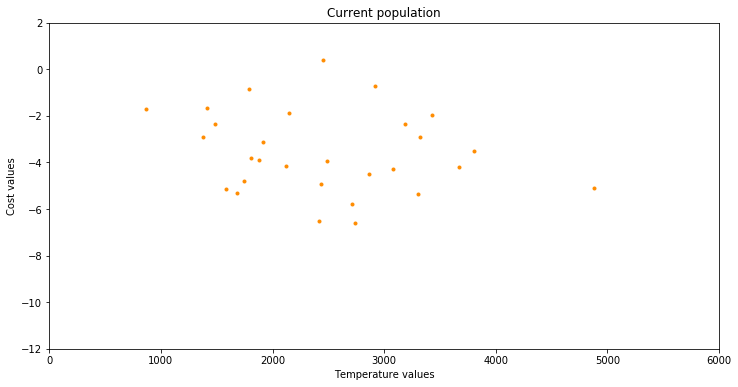

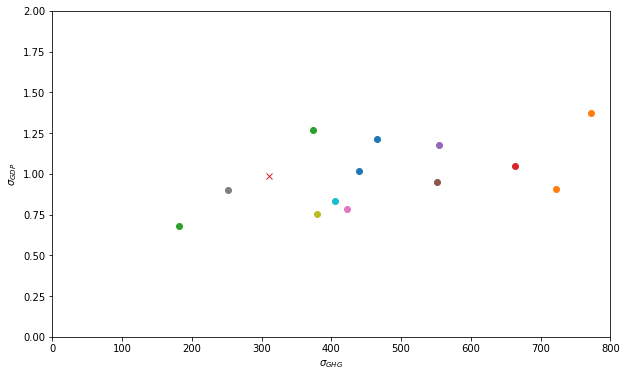

Sigmas are:  [[309.94865166131416, 0.9887854502705159]] Picking probability level:  7
Generation:  6 ; Fitness is:  -1.4925765122023784
Temperature and cost values:  [2978, -6.54] ;  [2586, -7.24]
Fittest candidate has fitness of:  -0.17612581624276902


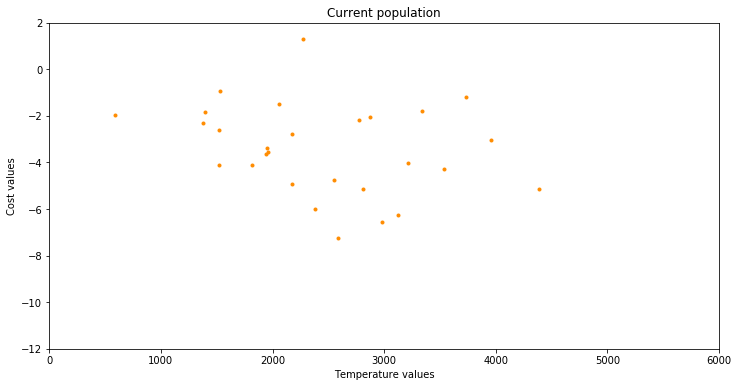

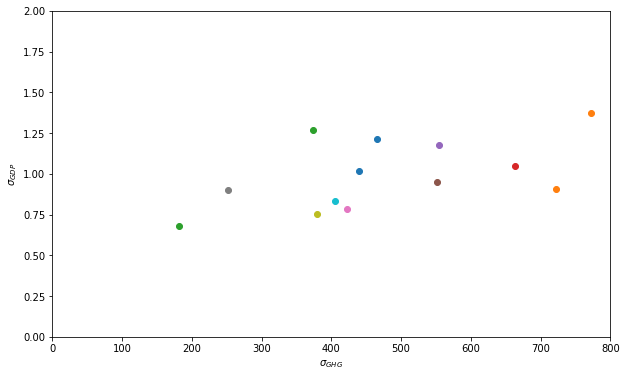

Sigmas are:  [[711.7981923738404, 9.766435719681294]] Picking probability level:  1
Generation:  7 ; Fitness is:  -1.9914148921679602
Temperature and cost values:  [1419, -4.6] ;  [2759, -6.99]
Fittest candidate has fitness of:  -0.7691773267962261


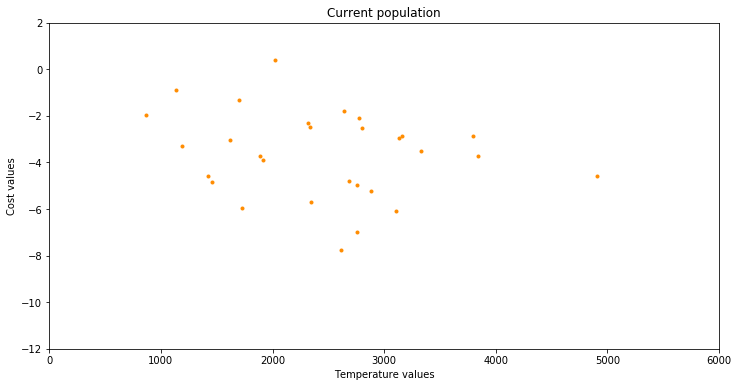

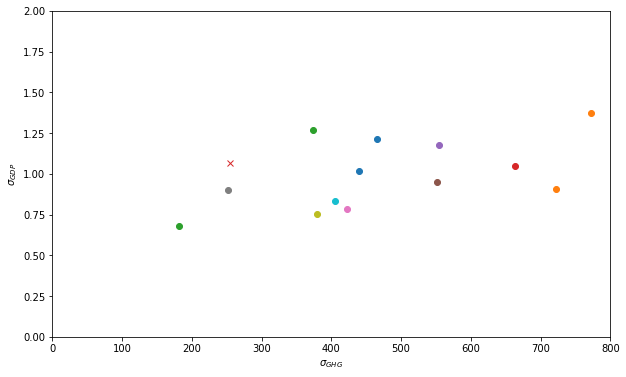

Sigmas are:  [[254.14326668239707, 1.0639063241971383]] Picking probability level:  7
Generation:  8 ; Fitness is:  -1.4870915048481437
Temperature and cost values:  [2489, -7.3] ;  [3144, -6.26]
Fittest candidate has fitness of:  -0.20239630234577138


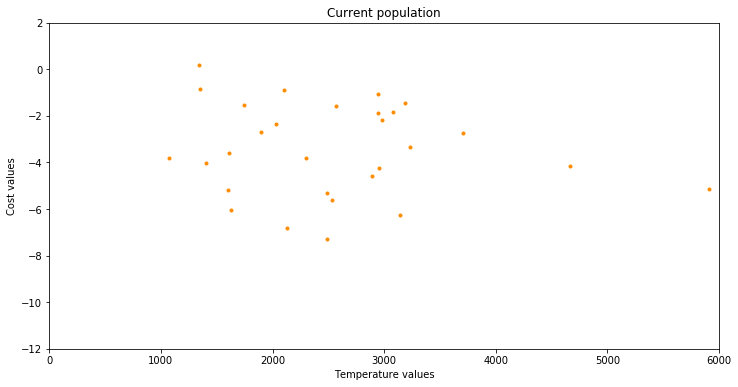

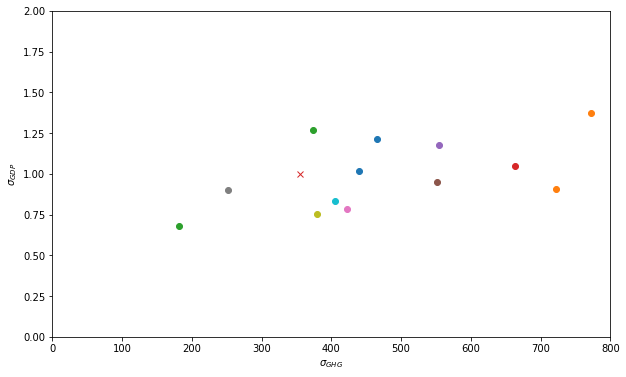

Sigmas are:  [[354.76114029959183, 1.0007397264024247]] Picking probability level:  12
Generation:  9 ; Fitness is:  -1.241846533499454
Temperature and cost values:  [3243, -7.68] ;  [3004, -5.79]
Fittest candidate has fitness of:  -0.18297439622501555


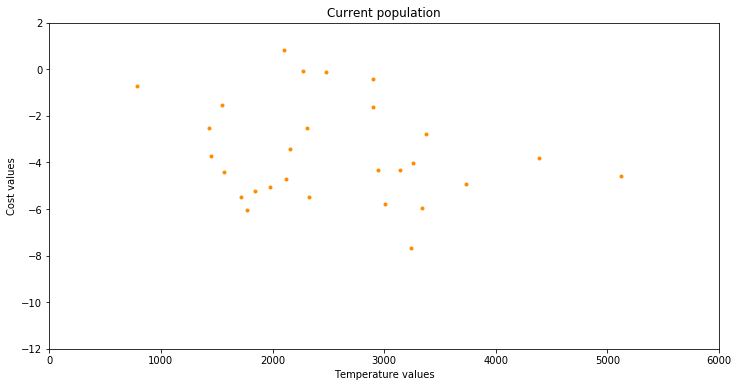

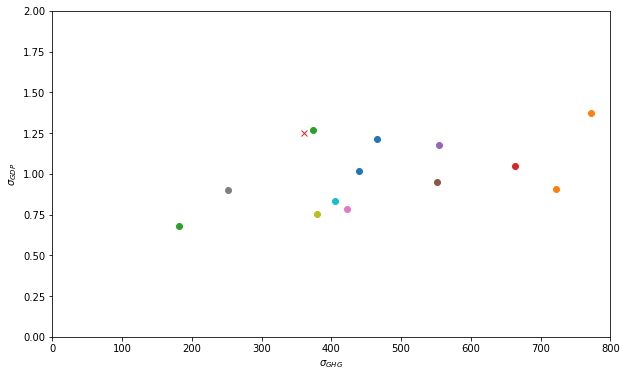

Sigmas are:  [[360.0381461271384, 1.2486913149373626]] Picking probability level:  12
Generation:  10 ; Fitness is:  -1.2564038825596233
Temperature and cost values:  [3263, -7.38] ;  [2921, -5.65]
Fittest candidate has fitness of:  -0.20868148497144115


In [166]:
fitness_progress, lever_vals = iterate(iterations = 10)

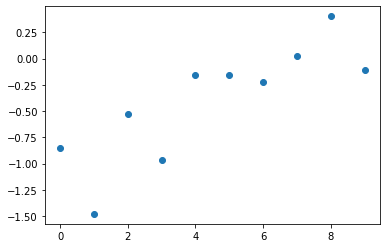

In [167]:
plt.plot([-0.8468611712847574,
  -1.4795059385315001,
  -0.5304027195317185,
  -0.9699041356506845,
  -0.1592101622377461,
  -0.15642432995889177,
  -0.22729112580939115,
  0.02672299875118224,
  0.4040100081492714,
  -0.10720557637949052], 'o')

## Specify constraints and iterate

In [190]:
# Specify input levers to fix
constraint_lever_names = ['Electric & hydrogen',
 'Global population',
 'Wind',
 'Nuclear',
 'Solar']
constraint_lever_values = [3, 2.0, 2.5, 1.0, 3.2]

# Specify input levers to bound within a threshold
threshold_names  = [ 'Calories consumed ',
 'Quantitiy of meat',
 'Type of meat ']
thresholds = [[2.5, 3.0], [2.5, 3.0], [2.5, 3.0]]

# Specify output constraints
output_constraint_names = ['Total energy demand (EJ / year)', 'Forest area (native and commercial, millions of hectares']
output_constraints = [420, 4100]

In [185]:
palette = itertools.cycle(sns.color_palette(palette = "pastel", n_colors = 16))

In [186]:
fitness_progress_temp = fitness_progress.copy()
c = next(palette)

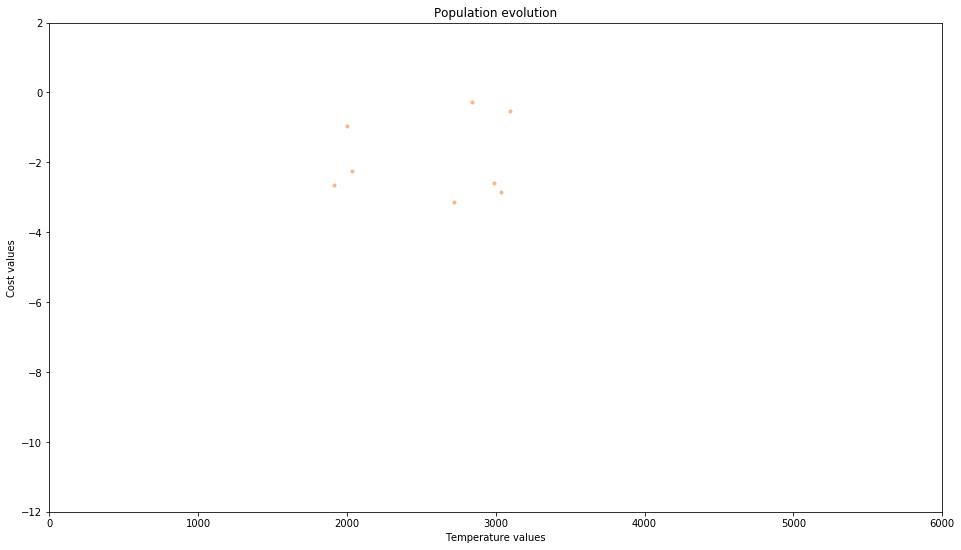

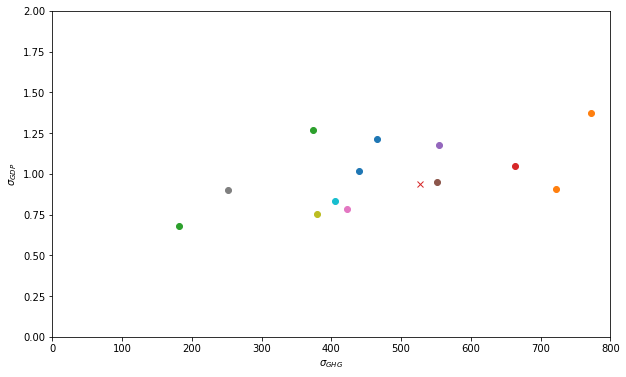

Sigmas are:  [[527.4123307874653, 0.9355568751640205]] Picking probability level:  5
Generation:  1 ; Fitness is:  0.05705306252648615
Temperature and cost values:  [3104, -0.75] ;  [2935, -0.46]
Fittest candidate has fitness of:  -0.08052613355694194


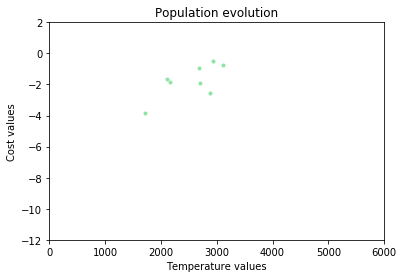

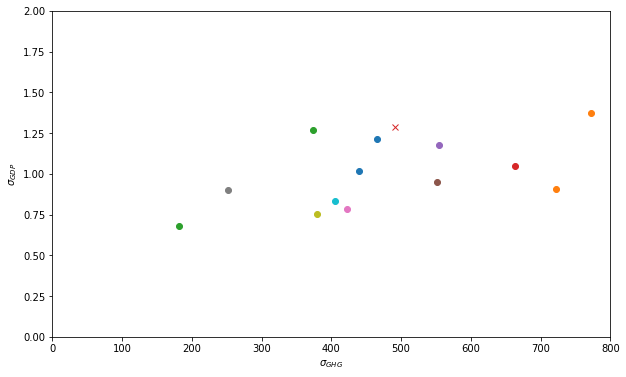

Sigmas are:  [[490.68727311802166, 1.2853274550349676]] Picking probability level:  0
Generation:  2 ; Fitness is:  0.20909454739100825
Temperature and cost values:  [2951, -3.69] ;  [1372, -4.12]
Fittest candidate has fitness of:  -0.06670125970637353


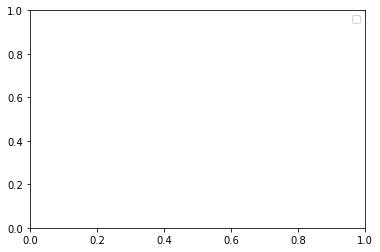

In [198]:
# Run GA optimiser
fitness_progress, lever_vals = iterate(iterations = 2, plot = True, population_size = 10, constraint = True, threshold = True, output_constraint = False, constraint_levers = constraint_lever_names, constraint_values = constraint_lever_values,  threshold_names = threshold_names, thresholds = thresholds, output_constraint_names = output_constraint_names, output_constraints = output_constraints)#, std_devs = std_devs)